1. (40 marks) Data preprocessing:

(a) Construct the return vector (for all dates except for the first date) by the formula:

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('^DJI.csv').loc[:,['Date', 'Adj Close']]
df['Date'] = pd.to_datetime(df['Date'],format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2014-01-02 to 2019-12-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1509 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


In [4]:
# Calculating the return vector
df['R'] = df['Adj Close'].pct_change()

df.head()

,Adj Close,R
Date,,
2014-01-02,16441.34961,NaN
2014-01-03,16469.99023,0.001742
2014-01-06,16425.09961,-0.002726
2014-01-07,16530.93945,0.006444
2014-01-08,16462.74023,-0.004126


(b) Data before 1 Jan 2019 are considered as training data and data in 2019 are considered as test data. In the .csv file, the column “Training” is the indicator of training data. For the better performance of using deep learning models, we apply MinMaxScalar on R (both training and test data) by the formula:


R.normedt = [Rt − min(R.train)] / [max(R.train) − min(R.train)]

where min(R.train) and max(R.train) are the minimum and maximum values of training data of R, respectively. Hence, R.normedt generally ranges from [0, 1] (test data may violate). In the .csv file, it is column “R.normed”.

In [7]:
# Subsetting the training and testing dataframes
df_train = df.loc['2018']
print(df_train.tail())

df_test = df.loc['2019']
print(df_test.head())

              Adj Close         R
Date                             
2018-12-24  21792.19922 -0.029100
2018-12-26  22878.44922  0.049846
2018-12-27  23138.82031  0.011381
2018-12-28  23062.40039 -0.003303
2018-12-31  23327.46094  0.011493
              Adj Close         R
Date                             
2019-01-02  23346.24023  0.000805
2019-01-03  22686.22070 -0.028271
2019-01-04  23433.16016  0.032925
2019-01-07  23531.34961  0.004190
2019-01-08  23787.44922  0.010883


In [9]:
from sklearn.preprocessing import MinMaxScaler


mmscaler= MinMaxScaler()
mmscaler.fit(df_train.loc[:,['R']])

df['R.normed'] = mmscaler.transform(df.loc[:,['R']])

print(df['R.normed'])

Date
2014-01-02         NaN
2014-01-03    0.498368
2014-01-06    0.451780
2014-01-07    0.547399
2014-01-08    0.437181
                ...   
2019-12-23    0.515545
2019-12-24    0.467025
2019-12-26    0.518945
2019-12-27    0.488899
2019-12-30    0.413539
Name: R.normed, Length: 1509, dtype: float64


(c) Suppose that our predictive analytics is to use the most recent 5 (transformed) returns to predict the next (transformed) return. Using the rolling-window approach
introduced in Lecture 9 to construct samples of subsequences of R.normed and the
corresponding output (next return). Recall that from a sequence (a1, a2, a3, a4, a5, a6, a7, . . .),
we construct the input matrix X and output matrix Y as follows:
Define the training data: X.train and Y.train and test data: X.test and Y.test. For
you to double check, the date of first Y.train should be 10 January 2014 and the
date of first Y.test should be 2 January 2019. In the .csv file, both training and
test data are under columns “X1”, “X2”, “X3”, “X4”, “X5”, and “Y”.

In [10]:
# Using the rolling window approach
timesteps = 5; dayahead = 1

Y = np.zeros(shape=(len(df) - timesteps - dayahead + 1, dayahead))
for i in range(dayahead):
    Y[:, i] = df['R.normed'][timesteps + i: len(df) - dayahead + i + 1]

X = np.zeros(shape=(len(df) - timesteps - dayahead + 1, timesteps))
for i in range(timesteps):
    X[:, i] = df['R.normed'][i: len(Y) + i]

# Creating the X & Y dataframes - the index is created from the original dataframe minus the first 5 rows. The first row is also dropped to prevent errors
X = pd.DataFrame(X, index=df.iloc[5:, ].index).iloc[1:, ]
Y = pd.DataFrame(Y, index=df.iloc[5:, ].index).iloc[1:, ]

# Renaming the columns and creating the training and testing dataframes
X = X.rename({0: 'X1', 1: 'X2', 2: 'X3', 3: 'X4', 4: 'X5'}, axis=1)
Y = Y.rename({0: 'Y'}, axis=1)

X_train = X.loc[:'2018', ]
X_test = X.loc['2019':, ]

Y_train = Y.loc[:'2018', ]
Y_test = Y.loc['2019':, ]

print(X_train.head())
print(Y_train.head())

                  X1        X2        X3        X4        X5
Date                                                        
2014-01-10  0.498368  0.451780  0.547399  0.437181  0.468813
2014-01-13  0.451780  0.547399  0.437181  0.468813  0.475314
2014-01-14  0.547399  0.437181  0.468813  0.475314  0.366570
2014-01-15  0.437181  0.468813  0.475314  0.366570  0.554555
2014-01-16  0.468813  0.475314  0.366570  0.554555  0.549035
                   Y
Date                
2014-01-10  0.475314
2014-01-13  0.366570
2014-01-14  0.554555
2014-01-15  0.549035
2014-01-16  0.439121


2. (40 marks) Using Feedforward neural networks (FFNN):

(a) Train a two-hidden-layer FFNN using the training data. You are free to determine or just use the default values of the (hyper-)parameters. You are suggested to try different settings to see the impacts. However, one implementation
suffices for this question while you can simply use the settings in the table below.

In [13]:
# 2 layer nn
import tensorflow as tf
from tensorflow import keras
from keras import layers


# Create sequential model
model = keras.Sequential()

model.add(layers.Dense(128, input_shape = (X_train.shape[1],), activation='relu', name='layer1'))
model.add(layers.Dense(128, activation='relu', name='layer2'))
model.add(layers.Dense(1, activation='relu', name='output'))
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

ret_tf = model.fit(x = X_train, y = Y_train,
                    shuffle = False,
                    batch_size = 16,
                    epochs = 30)

#evaluate model
print(model.summary())

Epoch 1/30
79/79 [==============================] - 0s 744us/step - loss: 0.0167
Epoch 2/30
79/79 [==============================] - 0s 731us/step - loss: 0.0095
Epoch 3/30
79/79 [==============================] - 0s 718us/step - loss: 0.0092
Epoch 4/30
79/79 [==============================] - 0s 718us/step - loss: 0.0089
Epoch 5/30
79/79 [==============================] - 0s 718us/step - loss: 0.0087
Epoch 6/30
79/79 [==============================] - 0s 757us/step - loss: 0.0085
Epoch 7/30
79/79 [==============================] - 0s 718us/step - loss: 0.0084
Epoch 8/30
79/79 [==============================] - 0s 744us/step - loss: 0.0083
Epoch 9/30
79/79 [==============================] - 0s 718us/step - loss: 0.0082
Epoch 10/30
79/79 [==============================] - 0s 731us/step - loss: 0.0082
Epoch 11/30
79/79 [==============================] - 0s 705us/step - loss: 0.0081
Epoch 12/30
79/79 [==============================] - 0s 846us/step - loss: 0.0081
Epoch 13/30
79/79 [======

(b) Use the trained model in part (a) to predict for the test data (X.test). Note that
the predicted values are transformed returns. Hence, you need to first convert it
back to returns (R.predt) by reversing the formula in Q1(b) and then use the
return to recover the price prediction: S.predt = St−1 ∗ (1 + R.predt).

In [22]:
# predict
y_pred = model.predict(X_test)

# inverse scaling
R_pred = mmscaler.inverse_transform(y_pred)

# Converting the returns back to prices
df_test['R_pred'] = R_pred
df_test['Adj Close_pred'] = 0

for i in range(len(df_test)):
    # There is no prior return for the first row.
    # So, I'm assuming the return was equal to zero, and as such, I set the prediction to be equal to the adjusted close for that day.
    if i == 0:
        df_test.iloc[i, -1] = df_test.iloc[i, 0]
    else:
        df_test.iloc[i, -1] = df_test.iloc[i - 1, 0] * (1 + df_test.iloc[i, 2])

df_test.head()

,Adj Close,R,R_pred,Adj Close_pred
Date,,,,
2019-01-02,23346.24023,0.000805,-0.003454,23346.240230
2019-01-03,22686.22070,-0.028271,0.003167,23420.182195
2019-01-04,23433.16016,0.032925,-0.002402,22631.720546
2019-01-07,23531.34961,0.004190,-0.012634,23137.100425
2019-01-08,23787.44922,0.010883,-0.003768,23442.690140


(c) Compute the test mean absolute percentage error (MAPE) 

In [24]:
# compute MAPE
MAPE = np.mean(np.abs(df_test['Adj Close'] - df_test['Adj Close_pred']) / df_test['Adj Close'] )
print('The MAPE is {:%}' .format(MAPE))

The MAPE is 0.681557%


3. (20 marks) Using long-short term memory (LSTM) networks:

(a) Train a LSTM network with two hidden LSTM layers using the training data.
To this end, you are reminded to convert X to a 3D-array and Y to a matrix.
The number of variables is 1 in this case.

In [25]:
## convert to array
X_train = np.expand_dims(X_train, axis = 2)
Y_train = np.matrix(Y_train)

In [27]:
# LSTM

model = keras.Sequential()
model.add(layers.LSTM(128, activation = "tanh", input_shape = (5, 1), return_sequences=True, name='layer1'))
model.add(layers.LSTM(128, activation = "tanh", name='layer2'))
model.add(layers.Dense(1, name='output'))

model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

ret_tf = model.fit(x = X_train, y = Y_train,
                    shuffle = False,
                    batch_size = 16,
                    epochs = 30)


#evaluate model
print(model.summary())

Epoch 1/30
79/79 [==============================] - 3s 6ms/step - loss: 0.0142 - mean_absolute_error: 0.0841
Epoch 2/30
79/79 [==============================] - 0s 6ms/step - loss: 0.0098 - mean_absolute_error: 0.0722
Epoch 3/30
79/79 [==============================] - 0s 6ms/step - loss: 0.0092 - mean_absolute_error: 0.0700
Epoch 4/30
79/79 [==============================] - 0s 6ms/step - loss: 0.0089 - mean_absolute_error: 0.0680
Epoch 5/30
79/79 [==============================] - 0s 6ms/step - loss: 0.0087 - mean_absolute_error: 0.0667
Epoch 6/30
79/79 [==============================] - 0s 6ms/step - loss: 0.0085 - mean_absolute_error: 0.0658
Epoch 7/30
79/79 [==============================] - 0s 6ms/step - loss: 0.0084 - mean_absolute_error: 0.0651
Epoch 8/30
79/79 [==============================] - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0646
Epoch 9/30
79/79 [==============================] - 0s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0642
Epoch 10/30
79/79 [

(b) Use the trained model in part (a) to predict for the test data (X.test).

In [30]:
# Reshaping X_test & Y_test
X_test = np.expand_dims(X_test, axis = 2)
Y_test = np.matrix(Y_test)

# predict
y_pred_lstm = model.predict(X_test)

# Recovering the returns from the scaled returns
R_pred_lstm = mmscaler.inverse_transform(y_pred_lstm)

# Converting the returns back to prices
df_test['R_pred_lstm'] = R_pred_lstm
df_test['Adj Close_pred_lstm'] = 0

for i in range(len(df_test)):
    # There is no prior return for the first row.
    # So, I'm assuming the return was equal to zero, and as such, I set the prediction to be equal to the adjusted close for that day.
    if i == 0:
        df_test.iloc[i, -1] = df_test.iloc[i, 0]
    else:
        df_test.iloc[i, -1] = df_test.iloc[i - 1, 0] * (1 + df_test.iloc[i, -2])

df_test.head()

,Adj Close,R,R_pred,Adj Close_pred,R_pred_lstm,Adj Close_pred_lstm
Date,,,,,,
2019-01-02,23346.24023,0.000805,-0.003454,23346.240230,0.000037,23346.240230
2019-01-03,22686.22070,-0.028271,0.003167,23420.182195,-0.000706,23329.763510
2019-01-04,23433.16016,0.032925,-0.002402,22631.720546,-0.000289,22679.674474
2019-01-07,23531.34961,0.004190,-0.012634,23137.100425,0.000425,23443.130936
2019-01-08,23787.44922,0.010883,-0.003768,23442.690140,0.000100,23533.697968


(c) Compute the test mean absolute percentage error (MAPE).

In [31]:
# compute MAPE
MAPE = np.mean(np.abs(df_test['Adj Close'] - df_test['Adj Close_pred_lstm']) / df_test['Adj Close'] )
print('The MAPE is {:%}' .format(MAPE))

The MAPE is 0.555819%


Text(0.5, 0, 'Days')

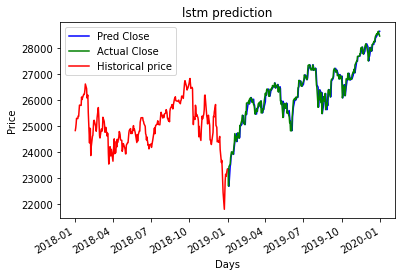

In [39]:
import matplotlib.pyplot as plt

ax2 = df_test['Adj Close_pred_lstm'].plot(color='b')
df_test['Adj Close'].plot(ax=ax2, color='g')
df['Adj Close']['2018'].plot(ax=ax2, color='r')
plt.legend(['Pred Close','Actual Close','Historical price'])
plt.title("lstm prediction")
plt.ylabel("Price")
plt.xlabel("Days")

Text(0.5, 0, 'Days')

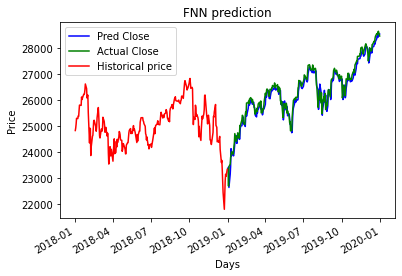

In [41]:
ax2 = df_test['Adj Close_pred'].plot(color='b')
df_test['Adj Close'].plot(ax=ax2, color='g')
df['Adj Close']['2018'].plot(ax=ax2, color='r')
plt.legend(['Pred Close','Actual Close','Historical price'])
plt.title("FNN prediction")
plt.ylabel("Price")
plt.xlabel("Days")